## Prepare datasets

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATA_PATH = "your data path"

## Import some Library

In [1]:
import torch
import torch.nn as nn
from PIL import Image
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'torch'

## Datasets Loader

In [ ]:
class CityScapes(torch.utils.data.DataLoader):
  def __init__(self, image_folder_path, mask_folder_path):
    pass

  def __len__(self):
    pass

  def __getitem(self, index):
    pass

## Model Architecture

- DoubleConv

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

- Unet

In [ ]:
class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # doblemconv, dobleconv..
        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        #upsam, doubleconv, up, ..
        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(#0
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))#1

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1] # reversed(skip_connections)

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

# FCN8s

In [ ]:
class FCN8s(nn.Module):
  def __init__(self, in_channels, out_channels, features= [64, 128, 256, 512, 1024]):
    super().__init__()
    self.layers = nn.ModuleList()
    self.pool = nn.MaxPool2d(2, 2)

    for feature in features:
      self.layers.append(DoubleConv(in_channels, feature))
      in_channels = feature

    self.ups1 = nn.ConvTranspose2d(features[-1], features[-2], kernel_size=2, stride=2)
    self.ups2 = nn.ConvTranspose2d(features[-1], features[-3], kernel_size=2, stride=2)

    self.predictions = nn.ConvTranspose2d(features[-2], out_channels, kernel_size=8, stride=8)

  def forward(self, x):
    skip_connections=[]

    for idx,layer in enumerate(self.layers):
      x = layer(x)
      x = self.pool(x)
      if idx in [2,3]:
        skip_connections.append(x)


    ups1 = self.ups1(x)
    concat1 = torch.concat([ups1, skip_connections[-1]], dim=1)

    ups2 = self.ups2(concat1)
    concat2 = torch.concat([ups2, skip_connections[-2]], dim=1)

    return self.predictions(concat2)

## Engine function

- Dice coefficient metrics

In [ ]:
def calculate_dice_coefficient(ground_truth, predicted):
    intersection = np.logical_and(ground_truth, predicted)
    dice_coefficient = (2 * np.sum(intersection)) / (np.sum(ground_truth) + np.sum(predicted))
    return dice_coefficient

def calculate_dice_coefficients(ground_truths, predictions):
    num_samples = len(ground_truths)
    dice_coefficients = np.zeros(num_samples)
    for i in range(num_samples):
        dice_coefficients[i] = calculate_dice_coefficient(ground_truths[i], predictions[i])
    return dice_coefficients

- training phase

In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, device):
  #please do training step in this function
  pass

def evaluate(model, dataloader, criterion, device):
  #please do evaluation step that calculate evaluation loss and evaluation metrics dice_score_coefficient
  pass

In [ ]:
def train():
  #please init everthing in here and do the training process
  pass

# BUATAN SENDIRI

In [1]:
print("a")

a


In [10]:
import torch
import torch.nn as nn
from PIL import Image
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
import matplotlib.pyplot as plt

In [11]:

class CityScapes(torch.utils.data.Dataset):
    def __init__(self, image_folder_path, mask_folder_path, transform=None):
        self.image_folder_path = image_folder_path
        self.mask_folder_path = mask_folder_path
        self.transform = transform
        self.images = os.listdir(image_folder_path)
        self.masks = os.listdir(mask_folder_path)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path = os.path.join(self.image_folder_path, self.images[index])
        mask_path = os.path.join(self.mask_folder_path, self.masks[index])

        image = Image.open(image_path)
        mask = Image.open(mask_path)

        if self.transform is not None:
            augmented = self.transform(image=np.array(image), mask=np.array(mask))
            image = augmented['image']
            mask = augmented['mask']

        return image, mask


In [29]:

transform = A.Compose([
    # A.Resize(256, 256),
    # A.HorizontalFlip(p=0.5),
    # A.VerticalFlip(p=0.5),
    # A.RandomRotate90(p=0.5),
    # A.Transpose(p=0.5),
    # A.Normalize(),
    ToTensorV2(),
])

image_folder_path = r"C:\Users\USER\Documents\2023\AI\3. Self-driving Car\data\images_prepped_train-20230811T065243Z-001\images_prepped_train"
mask_folder_path = r"C:\Users\USER\Documents\2023\AI\3. Self-driving Car\data\annotations_prepped_train-20230811T065240Z-001\annotations_prepped_train"

test_image_folder_path = r"C:\Users\USER\Documents\2023\AI\3. Self-driving Car\data\images_prepped_test-20230811T065241Z-001\images_prepped_test"
test_mask_folder_path = r"C:\Users\USER\Documents\2023\AI\3. Self-driving Car\data\annotations_prepped_test-20230811T065240Z-001\annotations_prepped_test"

train_dataset = CityScapes(
    image_folder_path=image_folder_path,
    mask_folder_path=mask_folder_path,
    transform=transform
)

test_dataset = CityScapes(
    image_folder_path=test_image_folder_path,
    mask_folder_path=test_mask_folder_path,
    transform=transform
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False)

In [27]:
import os

# Direktori dataset gambar dan masker
# image_folder_path = 'path_to_image_folder'
# mask_folder_path = 'path_to_mask_folder'

# Membuat set untuk melacak nama file gambar dan masker yang sudah ditemukan
image_files = set()
mask_files = set()

# Daftar file yang akan dihapus
files_to_delete = []

# Iterasi melalui direktori gambar
for image_file in os.listdir(image_folder_path):
    image_file_path = os.path.join(image_folder_path, image_file)
    
    # Mengambil nama file tanpa ekstensi
    image_name = os.path.splitext(image_file)[0]
    
    # Menambahkan nama file ke set
    image_files.add(image_name)

# Iterasi melalui direktori masker
for mask_file in os.listdir(mask_folder_path):
    mask_file_path = os.path.join(mask_folder_path, mask_file)
    
    # Mengambil nama file tanpa ekstensi
    mask_name = os.path.splitext(mask_file)[0]
    
    # Menambahkan nama file ke set
    mask_files.add(mask_name)

# Mencari file gambar yang tidak memiliki masker yang sesuai
for image_name in image_files:
    if image_name not in mask_files:
        files_to_delete.append(image_name + '.png')  # Menambahkan ekstensi file

# Menghapus file gambar yang tidak memiliki masker yang sesuai
for file_to_delete in files_to_delete:
    image_path_to_delete = os.path.join(image_folder_path, file_to_delete)
    os.remove(image_path_to_delete)
    print(f"File gambar {file_to_delete} telah dihapus.")

print("Proses penghapusan data duplikat selesai.")

File gambar 0016E5_07830(2).png telah dihapus.
File gambar 0006R0_f03810(1).png telah dihapus.
File gambar 0006R0_f03630(1).png telah dihapus.
File gambar 0006R0_f03720(1).png telah dihapus.
File gambar 0016E5_07710(2).png telah dihapus.
File gambar 0016E5_07650(1).png telah dihapus.
File gambar 0016E5_07710(1).png telah dihapus.
File gambar 0016E5_05400(1).png telah dihapus.
File gambar 0006R0_f03780(1).png telah dihapus.
File gambar 0016E5_07920(2).png telah dihapus.
File gambar 0016E5_07770(1).png telah dihapus.
File gambar 0006R0_f03750(1).png telah dihapus.
File gambar 0016E5_07680(1).png telah dihapus.
File gambar 0016E5_07860(2).png telah dihapus.
File gambar 0006R0_f03840(1).png telah dihapus.
File gambar 0016E5_07680(2).png telah dihapus.
File gambar 0006R0_f03690(1).png telah dihapus.
File gambar 0016E5_07620(1).png telah dihapus.
File gambar 0016E5_07920(1).png telah dihapus.
File gambar 0016E5_07740(2).png telah dihapus.
File gambar 0016E5_07800(1).png telah dihapus.
File g

In [21]:
print(f"Jumlah data pelatihan: {len(train_dataset)}")
print(f"Jumlah data pengujian: {len(test_dataset)}")

Jumlah data pelatihan: 398
Jumlah data pengujian: 101


In [30]:
print(f"Jumlah data pelatihan: {len(train_dataset)}")
print(f"Jumlah data pengujian: {len(test_dataset)}")

Jumlah data pelatihan: 367
Jumlah data pengujian: 101


In [31]:
print(f"Jumlah data pelatihan: {len(train_dataset)}")
print(f"Jumlah masker pelatihan: {len(train_dataset.masks)}")


Jumlah data pelatihan: 367
Jumlah masker pelatihan: 367


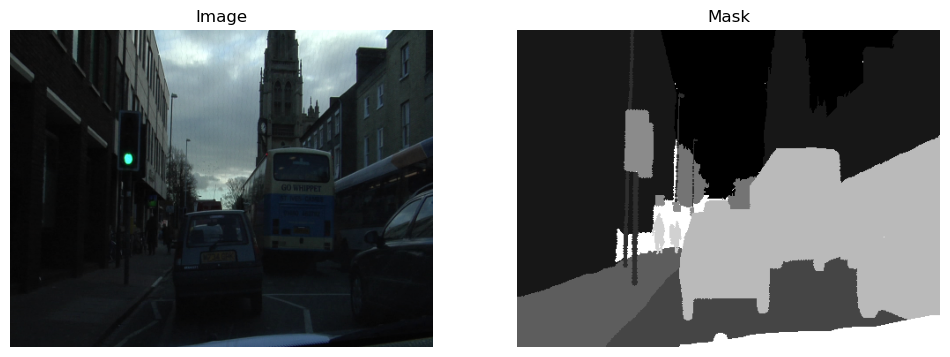

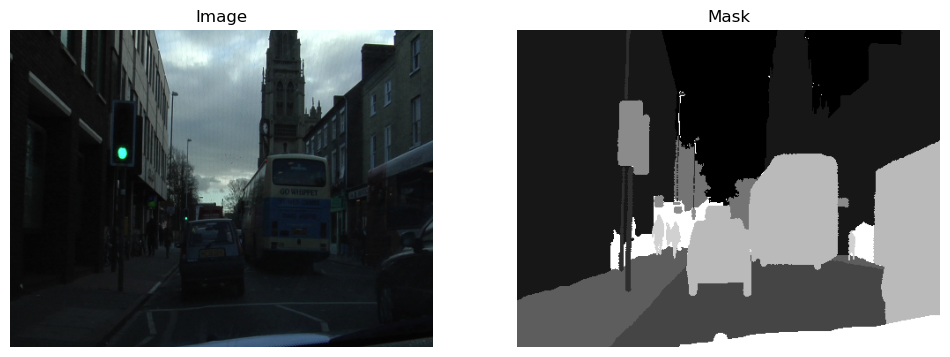

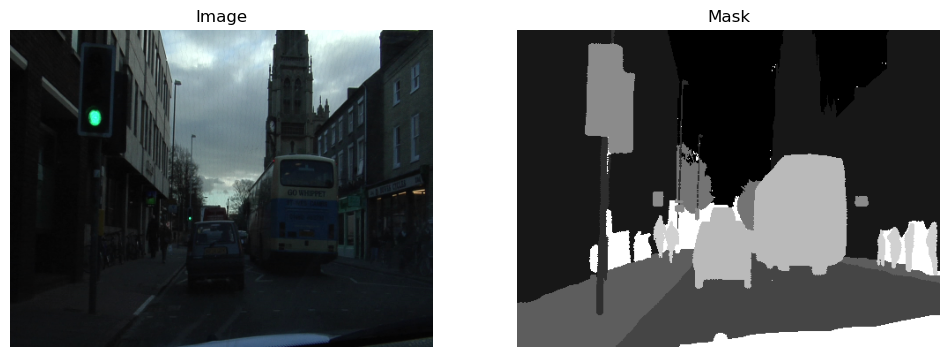

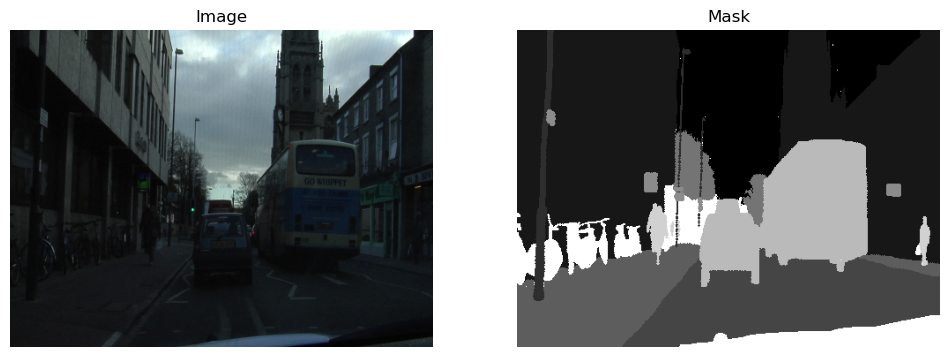

In [32]:
# Ambil beberapa contoh data dari dataset (misalnya, 4 contoh pertama)
num_samples_to_visualize = 4
samples = [(image, mask) for image, mask in train_dataset][:num_samples_to_visualize]

# Loop melalui contoh-contoh tersebut dan tampilkan gambar serta masknya
for i, (image, mask) in enumerate(samples):
    plt.figure(figsize=(12, 6))

    # Tampilkan gambar
    plt.subplot(1, 2, 1)
    plt.imshow(image.permute(1, 2, 0))  # Jika menggunakan PyTorch, permutasi dimensi
    plt.title('Image')
    plt.axis('off')

    # Tampilkan mask
    plt.subplot(1, 2, 2)
    plt.imshow(mask.squeeze(), cmap='gray')  # Squeeze mask jika perlu
    plt.title('Mask')
    plt.axis('off')

    plt.show()

In [33]:

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

In [34]:
class FCN8s(nn.Module):
    def __init__(self, in_channels, out_channels, features=[64, 128, 256, 512, 1024]):
        super().__init__()
        self.layers = nn.ModuleList()
        self.pool = nn.MaxPool2d(2, 2)

        for feature in features:
            self.layers.append(DoubleConv(in_channels, feature))
            in_channels = feature

        self.ups1 = nn.ConvTranspose2d(features[-1], features[-2], kernel_size=2, stride=2)
        self.ups2 = nn.ConvTranspose2d(features[-1], features[-3], kernel_size=2, stride=2)

        self.predictions = nn.ConvTranspose2d(features[-2], out_channels, kernel_size=8, stride=8)

    def forward(self, x):
        skip_connections = []

        for idx, layer in enumerate(self.layers):
            x = layer(x)
            x = self.pool(x)
            if idx in [2, 3]:
                skip_connections.append(x)

        ups1 = self.ups1(x)
        concat1 = torch.cat([ups1, skip_connections[-1]], dim=1)

        ups2 = self.ups2(concat1)
        concat2 = torch.cat([ups2, skip_connections[-2]], dim=1)

        return self.predictions(concat2)

## Perbaikan

In [17]:
class FCN8s(nn.Module):
    def __init__(self, in_channels, out_channels, features=[64, 128, 256, 512, 1024]):
        super().__init__()
        self.layers = nn.ModuleList()
        self.pool = nn.MaxPool2d(2, 2)

        for feature in features:
            self.layers.append(DoubleConv(in_channels, feature))
            in_channels = feature

        self.ups1 = nn.ConvTranspose2d(features[-1], features[-2], kernel_size=2, stride=2)
        self.ups2 = nn.ConvTranspose2d(features[-2], features[-3], kernel_size=2, stride=2)  # Perubahan di sini

        self.predictions = nn.ConvTranspose2d(features[-3], out_channels, kernel_size=8, stride=8)  # Perubahan di sini

    def forward(self, x):
        skip_connections = []

        for idx, layer in enumerate(self.layers):
            x = layer(x)
            x = self.pool(x)
            if idx in [2, 3]:
                skip_connections.append(x)

        ups1 = self.ups1(x)
        concat1 = torch.cat([ups1, skip_connections[-1]], dim=1)

        ups2 = self.ups2(concat1)
        concat2 = torch.cat([ups2, skip_connections[-2]], dim=1)

        return self.predictions(concat2)

In [59]:

def calculate_dice_coefficient(ground_truth, predicted):
    intersection = np.logical_and(ground_truth, predicted)
    dice_coefficient = (2 * np.sum(intersection)) / (np.sum(ground_truth) + np.sum(predicted))
    return dice_coefficient

def calculate_dice_coefficients(ground_truths, predictions):
    num_samples = len(ground_truths)
    dice_coefficients = np.zeros(num_samples)
    for i in range(num_samples):
        dice_coefficients[i] = calculate_dice_coefficient(ground_truths[i], predictions[i])
    return dice_coefficients

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        print(images)
        print(type(images))
        outputs = model(images)

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(dataloader)


def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    ground_truths = []
    predictions = []

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)

            loss = criterion(outputs, masks)
            running_loss += loss.item()

            predicted_masks = torch.sigmoid(outputs) > 0.5
            predictions.extend(predicted_masks.cpu().numpy())
            ground_truths.extend(masks.cpu().numpy())

    loss = running_loss / len(dataloader)
    dice_coefficients = calculate_dice_coefficients(ground_truths, predictions)

    return loss, np.mean(dice_coefficients)

In [68]:
torch.device("cuda" if torch.cuda.is_available() else "cpu")

device(type='cpu')

In [70]:
nvidia-smi

NameError: name 'nvidia' is not defined

In [66]:
def train():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    # Define your model, optimizer, and criterion here
    model = FCN8s(in_channels=3, out_channels=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCEWithLogitsLoss()

    num_epochs = 10
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        eval_loss, dice_score = evaluate(model, test_loader, criterion, device)

        print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f} Eval Loss: {eval_loss:.4f} Dice Score: {dice_score:.4f}")

        # Simpan checkpoint jika Dice Score terbaik tercapai
        if dice_score > best_dice_score:
            best_dice_score = dice_score
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': eval_loss,
                'dice_score': dice_score
            }
            torch.save(checkpoint, 'best_model_checkpoint.pth')

In [67]:
train()

cpu
tensor([[[[255, 255, 255,  ..., 251, 253, 254],
          [255, 255, 255,  ..., 251, 251, 252],
          [255, 255, 255,  ..., 251, 251, 252],
          ...,
          [ 50,  45,  46,  ..., 111, 109, 109],
          [ 47,  50,  50,  ..., 111, 111, 114],
          [ 48,  48,  50,  ..., 108, 109, 109]],

         [[255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          ...,
          [ 50,  45,  46,  ..., 111, 109, 109],
          [ 47,  50,  50,  ..., 111, 111, 114],
          [ 48,  48,  50,  ..., 108, 109, 109]],

         [[255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          ...,
          [ 52,  47,  48,  ..., 109, 107, 107],
          [ 50,  53,  53,  ..., 109, 109, 112],
          [ 50,  50,  52,  ..., 106, 107, 107]]],


        [[[105, 106,  80,  ..., 192, 255, 251],
          [103, 105,  80,  ...,

RuntimeError: expected scalar type Byte but found Float

In [ ]:
Masalah yang Anda alami terkait dengan dimensi tensor yang tidak cocok di lapisan upsampling. Salah satu solusinya adalah memastikan bahwa tensor yang Anda gabungkan memiliki ukuran yang sesuai dengan operasi torch.cat().

Dalam kode yang Anda bagikan, Anda menggunakan dua lapisan upsampling, yaitu self.ups1 dan self.ups2. Masing-masing dari lapisan ini membutuhkan perhatian khusus dalam menentukan ukuran keluaran agar sesuai dengan ukuran tensor skip-connection yang sesuai.

Berikut adalah kode perbaikan yang memperbaiki dimensi keluaran dari kedua lapisan upsampling agar sesuai dengan ukuran tensor skip-connection:

python
Copy code
class FCN8s(nn.Module):
    def __init__(self, in_channels, out_channels, features=[64, 128, 256, 512, 1024]):
        super().__init__()
        self.layers = nn.ModuleList()
        self.pool = nn.MaxPool2d(2, 2)

        for feature in features:
            self.layers.append(DoubleConv(in_channels, feature))
            in_channels = feature

        self.ups1 = nn.ConvTranspose2d(features[-1], features[-2], kernel_size=2, stride=2)
        self.ups2 = nn.ConvTranspose2d(features[-2], features[-3], kernel_size=2, stride=2)  # Perubahan di sini

        self.predictions = nn.ConvTranspose2d(features[-3], out_channels, kernel_size=8, stride=8)  # Perubahan di sini

    def forward(self, x):
        skip_connections = []

        for idx, layer in enumerate(self.layers):
            x = layer(x)
            x = self.pool(x)
            if idx in [2, 3]:
                skip_connections.append(x)

        ups1 = self.ups1(x)
        concat1 = torch.cat([ups1, skip_connections[-1]], dim=1)

        ups2 = self.ups2(concat1)
        concat2 = torch.cat([ups2, skip_connections[-2]], dim=1)

        return self.predictions(concat2)
Pada perubahan di atas, kami mengubah dimensi lapisan upsampling self.ups2 sehingga ukuran keluarannya sesuai dengan ukuran tensor skip_connections[-2]. Kami juga memastikan bahwa tensor yang akan digabungkan dalam operasi torch.cat() memiliki dimensi yang sesuai. Dengan perubahan ini, semoga masalah dimensi yang tidak cocok dapat diatasi.